# Introducción Modelos offline
A continuación utilizaremos el fichero creado anteriormente a partir del enviroment de recsim  de Interest Rate con DQN para evaluar diferentes modelos offline. Los modelos offline permiten, a partir de información de interacciones de usuario, generar un modelo de RL. En este caso, la principal diferencial con los modelos online es que no tienes el feedback directo del usuario a partir de las acciones realizadas. Para intentar trabajar con este problema, los modelos DQN asigna una probabilidad asociada a cada interacción que es utilizada con estos modelos.

<a id='model_pick'></a>
## Modelos offline de RL
RLlib tiene una gran cantidad de modelos offline que pueden ser utilizados para entrenar un modelo a partir de un fichero con interacciones del usuario con los productos.  Los modelos que veremos serán los siguientes:


- Behavior Cloning model (BC)
- Marwil
Para estos utilizaremos métricas offline ImportanceSampling y WeightedImportanceSampling.

Se han probado otros pero debido a la multi-dimensionalidad de este caso de uso, no eran válidos.

# Flujo
1. Se cargan los datos guardados en json del modelo DQN con el entorno InterestEvolution
2. Se genera el modelo BCTrainer con estos datos 
3. Se persiste este modelo para posteriormente levantar una API rest con el mismo
4. Se genera el modelo Marwil




<a id='recsim'></a>
# Librería recsim, entorno de RL

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Librerías estandar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from progressbar import ProgressBar
import os
# librerias para RL
import ray
from ray import tune
## environment
from ray.rllib.examples.env.recommender_system_envs_with_recsim import LongTermSatisfactionRecSimEnv, InterestEvolutionRecSimEnv
## agentes
from ray.rllib.agents.cql import CQLTrainer, CQL_DEFAULT_CONFIG
from ray.rllib.agents.marwil import MARWILTrainer, MARWILConfig
from ray.rllib.agents.marwil import BCTrainer, BCConfig # derivado del MARWIL
from ray.rllib.offline.estimators import (
    ImportanceSampling,
    WeightedImportanceSampling,
    DirectMethod,
    DoublyRobust,
)
#from ray.rllib.offline.estimators.fqe_torch_model import FQETorchModel


import gym  # RL environments and action/observation spaces




C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
C:\Users\Paul\AppData\Roa

In [3]:
# cargamos las funciones que hemos guardado dentro de la carpeta src
# nos permite compartir funciones en diferentes notebooks
import sys
sys.path.append('../src')
from models.rlmodels import  run_rlmodel_episode, run_simulation, run_rlmodel_episode_offline 
from visualization.visualize import plot_rewards_timestamp
from data.env import LTSWithStrongerDissatisfactionEffect 
from utils.docs import get_json_files

# Environment
A continuación vemos como es el entorno sobre el que vamos a entrenar nuestro agente

In [4]:
SEED = 0

## configuración del entorno: 20 posibles candidatos del que seleccionaremos 2
# mantendremos esta configuración para los demás agentes también
NUM_CANDIDATES = 20
SLATE_SIZE = 2
REGISTER_ENV_NAME = "env_ie"

# Load
Cargamos el fichero de long Interest Rate para utilizarlo posteriormente con los modelos offline. Usaremos el generado por el DQN con el entorno Interest Rate.

Para calcular las métrica de off-policy evaluation (OPE), necesitamos otro fichero sobre el que analizar los resultados de nuestros modelos. Por ello cargamos otro que será sobre el que evaluemos estos resultados

In [5]:
#OUTPUT_DIR = "C:\\Users\\Paul\\ray_results\\DQN_2022-09-01_17-40-13\\DQN_env_ie_5e8d7_00000_0_2022-09-01_17-40-13\\data"
json_output_file_evaluation = "C:\\Users\\Paul\\ray_results\\DQN_2022-09-01_17-40-13\\DQN_env_ie_5e8d7_00000_0_2022-09-01_17-40-13\\data\\output-2022-09-01_17-40-45_worker-0_1.json"
json_output_file = "C:\\Users\\Paul\\ray_results\\DQN_2022-09-01_17-40-13\\DQN_env_ie_5e8d7_00000_0_2022-09-01_17-40-13\\data\\output-2022-09-01_17-40-22_worker-0_0.json"
json_output_file


'C:\\Users\\Paul\\ray_results\\DQN_2022-09-01_17-40-13\\DQN_env_ie_5e8d7_00000_0_2022-09-01_17-40-13\\data\\output-2022-09-01_17-40-22_worker-0_0.json'

Cargamos el entorno que utilizaremos del modelo offline y que nos permitirá a posteriori añadir información a los modelos offline

In [6]:
offline_rl_env = InterestEvolutionRecSimEnv({
    "num_candidates": NUM_CANDIDATES,
    "slate_size": SLATE_SIZE,
    'resample_documents': False, # si resampleamos los documentos en cada episodio

    "wrap_for_bandits": False,  # SlateQ != Bandit
    "convert_to_discrete_action_space": True,
     "wrap_for_bandits": True,  
})



In [7]:
df = pd.read_json(json_output_file,lines=True)
df.head()

,type,obs,new_obs,actions,prev_actions,rewards,prev_rewards,dones,infos,t,eps_id,unroll_id,agent_index,q_values,action_dist_inputs,action_logp,action_prob,weights
0,SampleBatch,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,"[268, 210, 122, 331]","[268, 268, 210, 122]","[0.0, 4.0, 0.0, 4.0]","[0.0, 0.0, 4.0, 0.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[0, 1, 2, 3]","[1813382118, 1813382118, 1813382118, 1813382118]","[0, 0, 0, 0]","[0, 0, 0, 0]","[[-0.003961951471865, -0.004080994985997, -0.0...","[[-0.003961951471865, -0.004080994985997, -0.0...","[-5.992305755615234, -5.9906792640686035, -5.9...","[0.0024978979490690003, 0.0025019638705990003,...","[1.0, 1.0, 1.0, 1.0]"
1,SampleBatch,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,"[312, 208, 121, 258]","[331, 312, 208, 121]","[0.0, 0.0, 4.0, 0.0]","[4.0, 0.0, 0.0, 4.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[4, 5, 6, 7]","[1813382118, 1813382118, 1813382118, 1813382118]","[1, 1, 1, 1]","[0, 0, 0, 0]","[[-0.003961951471865, -0.004080994985997, -0.0...","[[-0.003961951471865, -0.004080994985997, -0.0...","[-5.9922075271606445, -5.994399070739746, -5.9...","[0.0024981433525680004, 0.0024926743935790004,...","[1.0, 1.0, 1.0, 1.0]"
2,SampleBatch,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,"[107, 316, 366, 145]","[258, 107, 316, 366]","[0.0, 4.0, 0.0, 0.0]","[0.0, 0.0, 4.0, 0.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[8, 9, 10, 11]","[1813382118, 1813382118, 1813382118, 1813382118]","[2, 2, 2, 2]","[0, 0, 0, 0]","[[-0.003961951471865, -0.004080994985997, -0.0...","[[-0.003961951471865, -0.004080994985997, -0.0...","[-5.994082450866699, -5.990517616271973, -5.99...","[0.002493463689461, 0.0025023685302580003, 0.0...","[1.0, 1.0, 1.0, 1.0]"
3,SampleBatch,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,"[388, 372, 52, 121]","[145, 388, 372, 52]","[4.0, 4.0, 0.0, 0.0]","[0.0, 4.0, 4.0, 0.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[12, 13, 14, 15]","[1813382118, 1813382118, 1813382118, 1813382118]","[3, 3, 3, 3]","[0, 0, 0, 0]","[[-0.003961951471865, -0.004080994985997, -0.0...","[[-0.003961951471865, -0.004080994985997, -0.0...","[-5.989788055419922, -5.990357398986816, -5.99...","[0.0025041948538270004, 0.002502769464626, 0.0...","[1.0, 1.0, 1.0, 1.0]"
4,SampleBatch,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,"[16, 322, 107, 243]","[121, 16, 322, 107]","[4.0, 4.0, 0.0, 0.0]","[0.0, 4.0, 4.0, 0.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[16, 17, 18, 19]","[1813382118, 1813382118, 1813382118, 1813382118]","[4, 4, 4, 4]","[0, 0, 0, 0]","[[-0.003961951471865, -0.004080994985997, -0.0...","[[-0.003961951471865, -0.004080994985997, -0.0...","[-5.992752552032471, -5.990224361419678, -5.99...","[0.0024967819917940002, 0.0025031024124470003,...","[1.0, 1.0, 1.0, 1.0]"


In [8]:
df.shape

(991, 18)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   type                991 non-null    object
 1   obs                 991 non-null    object
 2   new_obs             991 non-null    object
 3   actions             991 non-null    object
 4   prev_actions        991 non-null    object
 5   rewards             991 non-null    object
 6   prev_rewards        991 non-null    object
 7   dones               991 non-null    object
 8   infos               991 non-null    object
 9   t                   991 non-null    object
 10  eps_id              991 non-null    object
 11  unroll_id           991 non-null    object
 12  agent_index         991 non-null    object
 13  q_values            991 non-null    object
 14  action_dist_inputs  991 non-null    object
 15  action_logp         991 non-null    object
 16  action_prob         991 no

## Análisis de los datos offline

In [10]:
def explode_df(df, cols):
    df_exp = df[cols].apply(pd.Series.explode).reset_index()
    return df_exp

def clean_cols_exploded(df_exp):
    cols_to_float = ["rewards","prev_rewards","action_prob","dones"]
    df_exp[cols_to_float] = df_exp[cols_to_float].astype("float")
    cols_to_cat = ["eps_id","unroll_id"]
    df_exp[cols_to_cat] = df_exp[cols_to_cat].astype("category")
    return df_exp


cols = ["eps_id","unroll_id","actions","prev_actions","t","rewards","prev_rewards","action_prob","q_values","dones"]

df_exp = explode_df(df, cols)
df_exp = clean_cols_exploded(df_exp)


df_exp.head()


,index,eps_id,unroll_id,actions,prev_actions,t,rewards,prev_rewards,action_prob,q_values,dones
0,0,1813382118,0,268,268,0,0.0,0.0,0.002498,"[-0.003961951471865, -0.004080994985997, -0.00...",0.0
1,0,1813382118,0,210,268,1,4.0,0.0,0.002502,"[-0.003961951471865, -0.004080994985997, -0.00...",0.0
2,0,1813382118,0,122,210,2,0.0,4.0,0.002495,"[-0.003961951471865, -0.004080994985997, -0.00...",0.0
3,0,1813382118,0,331,122,3,4.0,0.0,0.002504,"[-0.003961951471865, -0.004080994985997, -0.00...",0.0
4,1,1813382118,1,312,331,4,0.0,4.0,0.002498,"[-0.003961951471865, -0.004080994985997, -0.00...",0.0


In [11]:
df_exp.describe(include="all")

,index,eps_id,unroll_id,actions,prev_actions,t,rewards,prev_rewards,action_prob,q_values,dones
count,3964.000000,3964.0,3964.0,3964.0,3964.0,3964.0,3964.000000,3964.000000,3964.000000,3964,3964.000000
unique,NaN,47.0,1027.0,400.0,400.0,119.0,NaN,NaN,NaN,742,NaN
top,NaN,264734896.0,0.0,78.0,78.0,0.0,NaN,NaN,NaN,"[-0.003961951471865, -0.004080994985997, -0.00...",NaN
freq,NaN,119.0,4.0,33.0,33.0,47.0,NaN,NaN,NaN,1000,NaN
mean,495.000000,NaN,NaN,NaN,NaN,NaN,1.773784,1.766460,0.004192,NaN,0.011604
std,286.113004,NaN,NaN,NaN,NaN,NaN,1.982973,1.984927,0.003324,NaN,0.107111
min,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000162,NaN,0.000000
25%,247.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.002494,NaN,0.000000
50%,495.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.002548,NaN,0.000000
75%,743.000000,NaN,NaN,NaN,NaN,NaN,4.000000,4.000000,0.005380,NaN,0.000000


Por lo que vemos, tenemos un total de 399 acciones diferentes, un total de 50 episodios diferentes con hasta 126 timesteps. 

El máximo reward es de 4, mientras que el mínimo como es lógico es de 0. El promedio se sitúa en 1.81.

Text(0.5, 1.0, 'histograma de action prob (train set)')

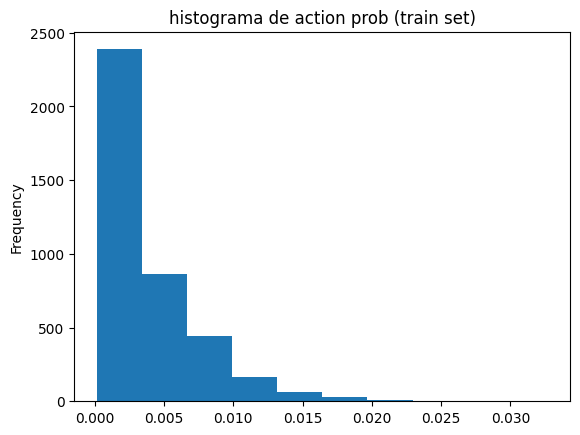

In [12]:
df_exp.action_prob.plot(kind="hist")
plt.title("histograma de action prob (train set)")

Veamos cuales son los rewards promedio de las acciones y los ordenamos para ver aquellas acciones que dan un mayor reward. Filtramos para aquellas acciones que se han producido más de 12 veces debido a que las de pocas apariciones pueden tener una media del reward alta al haberse producido pocas veces.

In [13]:
actionsbyrew = df_exp.groupby("actions").rewards.agg(["mean","count"])
actionsbyrew = actionsbyrew[((actionsbyrew["count"]>12))]
actionsbyrew.sort_values("mean",ascending=False)

,mean,count
actions,,
185,3.058824,17
245,2.814815,27
129,2.800000,20
149,2.769231,13
226,2.709677,31
...,...,...
306,1.333333,15
44,1.250000,16
282,1.230769,13


Text(0.5, 1.0, 'histograma de medias de rewards (train set) por acción para acciones con más de 12 ocurrencias')

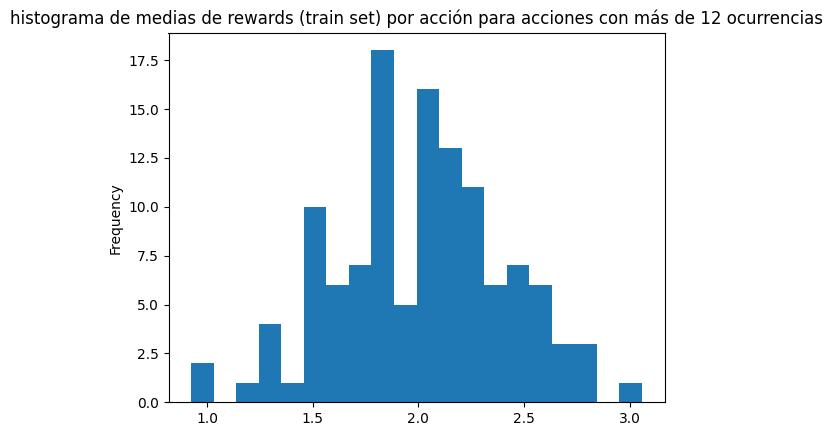

In [14]:
actionsbyrew["mean"].plot(kind="hist",bins=20)
plt.title("histograma de medias de rewards (train set) por acción para acciones con más de 12 ocurrencias")

Veamos ahora si el reward suele ser cero para una determinada acción.

Text(0.5, 1.0, 'Porcentaje de rewards nulos por acción (train set)')

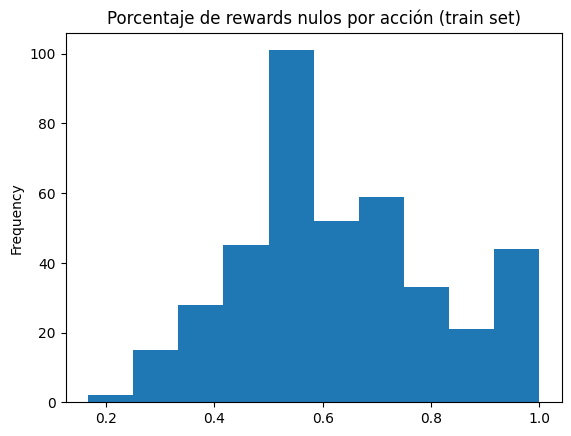

In [23]:
df_exp.groupby("actions").rewards.agg(lambda x: sum(x==0)/len(x)).plot(kind="hist")
plt.title("Porcentaje de rewards nulos por acción (train set)")

Vemos aquí que cada acción suele tener alrededor de un 50% de rewards nulos y el otro positivos mayores que cero.

### Análisis del fichero de evaluación

In [16]:
df_ev = pd.read_json(json_output_file_evaluation,lines=True)
df_ev.head()

,type,obs,new_obs,actions,prev_actions,rewards,prev_rewards,dones,infos,t,eps_id,unroll_id,agent_index,q_values,action_dist_inputs,action_logp,action_prob,weights
0,SampleBatch,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,"[258, 58, 374, 55]","[364, 258, 58, 374]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[47, 48, 49, 50]","[1109658755, 1109658755, 1109658755, 1109658755]","[1027, 1027, 1027, 1027]","[0, 0, 0, 0]","[[15.685279846191406, 15.421998977661133, 14.0...","[[15.685279846191406, 15.421998977661133, 14.0...","[-7.300140380859375, -4.897860527038574, -5.33...","[0.000675443967338, 0.007462531793862001, 0.00...","[1.0, 1.0, 1.0, 1.0]"
1,SampleBatch,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,"[226, 48, 197, 55]","[55, 226, 48, 197]","[4.0, 0.0, 4.0, 4.0]","[0.0, 4.0, 0.0, 4.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[51, 52, 53, 54]","[1109658755, 1109658755, 1109658755, 1109658755]","[1028, 1028, 1028, 1028]","[0, 0, 0, 0]","[[15.557333946228027, 15.320795059204102, 13.9...","[[15.557333946228027, 15.320795059204102, 13.9...","[-3.9688994884490962, -4.296158790588379, -5.2...","[0.018894214183092003, 0.013620778918266001, 0...","[1.0, 1.0, 1.0, 1.0]"
2,SampleBatch,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,"[181, 92, 142, 116]","[55, 181, 92, 142]","[0.0, 0.0, 0.0, 0.0]","[4.0, 0.0, 0.0, 0.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[55, 56, 57, 58]","[1109658755, 1109658755, 1109658755, 1109658755]","[1029, 1029, 1029, 1029]","[0, 0, 0, 0]","[[15.255053520202637, 15.05372428894043, 13.70...","[[15.255053520202637, 15.05372428894043, 13.70...","[-5.065549850463867, -6.6923322677612305, -5.5...","[0.006310440134257, 0.001240386511199, 0.00381...","[1.0, 1.0, 1.0, 1.0]"
3,SampleBatch,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,"[165, 174, 119, 225]","[116, 165, 174, 119]","[0.0, 4.0, 0.0, 0.0]","[0.0, 0.0, 4.0, 0.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[59, 60, 61, 62]","[1109658755, 1109658755, 1109658755, 1109658755]","[1030, 1030, 1030, 1030]","[0, 0, 0, 0]","[[14.899430274963379, 14.733202934265137, 13.3...","[[14.899430274963379, 14.733202934265137, 13.3...","[-6.127820491790771, -6.252415180206299, -5.24...","[0.002181329997256, 0.0019257973181080002, 0.0...","[1.0, 1.0, 1.0, 1.0]"
4,SampleBatch,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,"[48, 24, 149, 128]","[225, 48, 24, 149]","[0.0, 4.0, 4.0, 0.0]","[0.0, 0.0, 4.0, 4.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[63, 64, 65, 66]","[1109658755, 1109658755, 1109658755, 1109658755]","[1031, 1031, 1031, 1031]","[0, 0, 0, 0]","[[14.712350845336914, 14.580305099487305, 13.2...","[[14.712350845336914, 14.580305099487305, 13.2...","[-4.484161376953125, -5.423988342285156, -5.00...","[0.011286348104476, 0.004409524612128, 0.00669...","[1.0, 1.0, 1.0, 1.0]"


In [17]:
df_ev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   type                1028 non-null   object
 1   obs                 1028 non-null   object
 2   new_obs             1028 non-null   object
 3   actions             1028 non-null   object
 4   prev_actions        1028 non-null   object
 5   rewards             1028 non-null   object
 6   prev_rewards        1028 non-null   object
 7   dones               1028 non-null   object
 8   infos               1028 non-null   object
 9   t                   1028 non-null   object
 10  eps_id              1028 non-null   object
 11  unroll_id           1028 non-null   object
 12  agent_index         1028 non-null   object
 13  q_values            1028 non-null   object
 14  action_dist_inputs  1028 non-null   object
 15  action_logp         1028 non-null   object
 16  action_prob         1028

In [18]:
df_ev.shape

(1028, 18)

In [19]:
df_ev_exp = explode_df(df_ev, cols)
df_ev_exp = clean_cols_exploded(df_ev_exp)

Text(0.5, 1.0, 'histograma de action prob (validation set)')

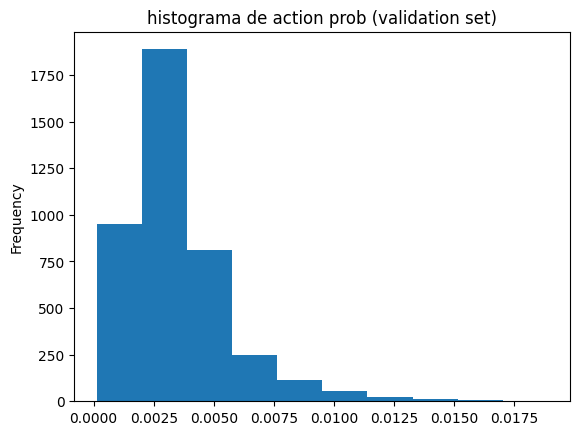

In [22]:
df_ev_exp.action_prob.plot(kind="hist")
plt.title("histograma de action prob (validation set)")

Text(0.5, 1.0, 'Porcentaje de rewards nulos por acción (validation set)')

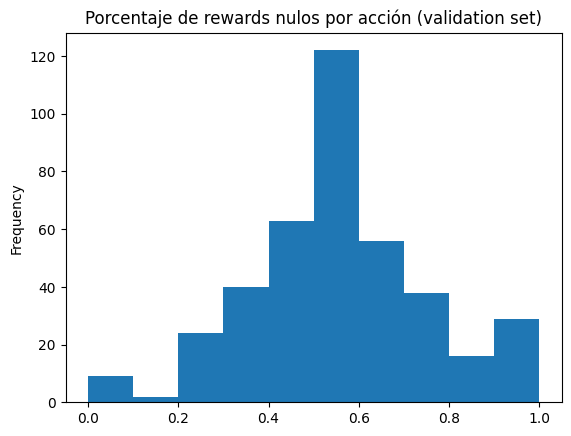

In [21]:
df_ev_exp.groupby("actions").rewards.agg(lambda x: sum(x==0)/len(x)).plot(kind="hist")
plt.title("Porcentaje de rewards nulos por acción (validation set)")

## BC Trainer

A continuación configuramos un nuevo trainer de RLlib offline a partir del Config que nos proporciona la librería.

In [22]:
MODEL_NAME = "BCTrainer"
config = (
    BCConfig()
    .environment(env=None)
    .framework("torch")
    .offline_data(input_=[json_output_file])
    .evaluation(
        evaluation_interval=1,
        evaluation_duration=10,
        evaluation_num_workers=1,
        evaluation_duration_unit="episodes",
        evaluation_config={"input": [json_output_file_evaluation]},
        off_policy_estimation_methods={
            "is": {"type": ImportanceSampling},
            "wis": {"type": WeightedImportanceSampling},
           
            },
        #},
    )
)
# hemos puesto en env a None por lo que tenemos que darle esta info al modelo offline
config.observation_space = offline_rl_env.observation_space 
config.action_space = offline_rl_env.action_space
bc_trainer = config.build()

2022-09-12 19:40:02,408	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(
2022-09-12 19:40:05,765	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2022-09-12 19:40:08,450	WARNING deprecation.py:47 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-09-12 19:40:08,451	WARNING deprecation.py:47 -- DeprecationWarning: 

En este caso recordemos que no vamos a tener rewards, debido a que no tenemos un entorno que devuelve estos valores en función de las interacciones desarrolladas por el agente. Por ello es necesario utilizar métricas diferentes.

In [23]:
for _ in range(10):
    results = bc_trainer.train()
    print(f"{results['info']['num_agent_steps_trained']} steps trained; loss = {results['info']['learner']['default_policy']['learner_stats']['total_loss']};  reward = {results['episode_reward_mean']}")

2022-09-12 19:40:15,084	WARNING multi_agent_prioritized_replay_buffer.py:220 -- Adding batches with column `weights` to this buffer while providing weights as a call argument to the add method results in the column being overwritten.
2022-09-12 19:40:15,136	WARNING deprecation.py:47 -- DeprecationWarning: `concat_samples` has been deprecated. Use `concat_samples() from rllib.policy.sample_batch` instead. This will raise an error in the future!


2000 steps trained; loss = 5.991345405578613;  reward = nan
4000 steps trained; loss = 5.990023136138916;  reward = nan
6000 steps trained; loss = 5.98827600479126;  reward = nan
8000 steps trained; loss = 5.986507892608643;  reward = nan
10000 steps trained; loss = 5.9845194816589355;  reward = nan
12000 steps trained; loss = 5.9828057289123535;  reward = nan
14000 steps trained; loss = 5.981024742126465;  reward = nan
16000 steps trained; loss = 5.979801177978516;  reward = nan
18000 steps trained; loss = 5.977792739868164;  reward = nan
20000 steps trained; loss = 5.976598262786865;  reward = nan


### Estimadores Offpolicy

In [24]:
results.keys()

dict_keys(['evaluation', 'custom_metrics', 'episode_media', 'num_recreated_workers', 'info', 'sampler_results', 'episode_reward_max', 'episode_reward_min', 'episode_reward_mean', 'episode_len_mean', 'episodes_this_iter', 'policy_reward_min', 'policy_reward_max', 'policy_reward_mean', 'hist_stats', 'sampler_perf', 'num_faulty_episodes', 'num_healthy_workers', 'num_agent_steps_sampled', 'num_agent_steps_trained', 'num_env_steps_sampled', 'num_env_steps_trained', 'num_env_steps_sampled_this_iter', 'num_env_steps_trained_this_iter', 'timesteps_total', 'num_steps_trained_this_iter', 'agent_timesteps_total', 'timers', 'counters', 'done', 'episodes_total', 'training_iteration', 'trial_id', 'experiment_id', 'date', 'timestamp', 'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip', 'config', 'time_since_restore', 'timesteps_since_restore', 'iterations_since_restore', 'warmup_time', 'perf'])

In [25]:
ope_results = results["evaluation"]['off_policy_estimator']
print(f"IS off-policy estimation: {ope_results['is']}")
print(f"WIS off-policy estimation: {ope_results['wis']}")

IS off-policy estimation: {'v_behavior': 102.3383017289212, 'v_target': 39.19983475692854, 'v_gain': 0.3798371692290948, 'v_behavior_std': 13.475497117477964, 'v_target_std': 75.73763938167971, 'v_gain_std': 0.7211452739605825}
WIS off-policy estimation: {'v_behavior': 102.3383017289212, 'v_target': 104.67623268526674, 'v_gain': 1.0086988521645235, 'v_behavior_std': 13.475497117477964, 'v_target_std': 248.3838109090856, 'v_gain_std': 2.336648258911005}


In [26]:
ope_results

{'is': {'v_behavior': 102.3383017289212,
  'v_target': 39.19983475692854,
  'v_gain': 0.3798371692290948,
  'v_behavior_std': 13.475497117477964,
  'v_target_std': 75.73763938167971,
  'v_gain_std': 0.7211452739605825},
 'wis': {'v_behavior': 102.3383017289212,
  'v_target': 104.67623268526674,
  'v_gain': 1.0086988521645235,
  'v_behavior_std': 13.475497117477964,
  'v_target_std': 248.3838109090856,
  'v_gain_std': 2.336648258911005}}

Ejecución del modelo

In [27]:
NUM_EPISODES = 150
results = run_simulation(bc_trainer,num_episodes = NUM_EPISODES, func = run_rlmodel_episode_offline)


100%|██████████| 150/150 [25:41<00:00, 10.28s/it]


In [28]:
def get_offline_metrics(results,model=None):
    iss,wiss, losses=[], [], []
    for result in results:
        if type(result) == list:
            
            for r in result:
                losses.append(r["loss"])
                iss.append(r["is"])
                wiss.append(r["wis"])
    is_df = pd.DataFrame(iss).rename_axis('num_episode').assign(offline_method="IS")
    wis_df = pd.DataFrame(wiss).rename_axis('num_episode').assign(offline_method="WIS")
    loss_df = pd.Series(losses).rename("loss").to_frame().rename_axis('num_episode').assign(offline_method="loss") 

    return pd.concat([is_df, wis_df, loss_df],axis=0).assign(model=model).assign(time=results[1])


In [29]:
offline_metrics = get_offline_metrics(results,model = MODEL_NAME)

In [30]:
offline_metrics.head()

,v_behavior,v_target,v_gain,v_behavior_std,v_target_std,v_gain_std,offline_method,loss,model,time
num_episode,,,,,,,,,,
0,102.619356,39.182968,0.378720,13.247511,76.224650,0.724945,IS,NaN,BCTrainer,1541.399937
1,102.522018,39.561121,0.382448,13.163751,76.654479,0.729418,IS,NaN,BCTrainer,1541.399937
2,102.443820,39.644894,0.384783,12.887895,77.078413,0.733617,IS,NaN,BCTrainer,1541.399937
3,102.546519,37.587165,0.363779,12.869636,71.605778,0.679060,IS,NaN,BCTrainer,1541.399937
4,102.667207,40.520922,0.392761,13.466870,78.023716,0.742317,IS,NaN,BCTrainer,1541.399937


Persistencia del modelo (también en ray results)

In [31]:
checkpoint_dir = f"../models/offline_rl/interest_evolution/{MODEL_NAME}"
# We use the `Trainer.save()` method to create a checkpoint.
checkpoint_file = bc_trainer.save(checkpoint_dir)
print(f"Trainer en iteración {bc_trainer.iteration} guardado en '{checkpoint_file}'.")
offline_metrics.to_csv(os.path.join(checkpoint_dir,"offline_metrics.csv"))

Trainer en iteración 160 guardado en '../models/offline_rl/interest_evolution/BCTrainer\checkpoint_000160'.


Probamos a restaurar el modelo

In [32]:
new_bc_trainer = config.build()
print(f"Antes de cargarlo: Trainer está en la iteración={new_bc_trainer.iteration}")
new_bc_trainer.restore(checkpoint_file)
print(f"Después de cargarlo: Trainer está en la iteración={new_bc_trainer.iteration}")

2022-09-12 20:07:42,571	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(
2022-09-12 20:07:42,589	WARNING deprecation.py:47 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-09-12 20:07:42,589	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will 

Before restoring: Trainer is at iteration=0
After restoring: Trainer is at iteration=160


Marwil model

A continuación ejecutaremos el modelo marwil y evaluaremos su performance

In [33]:
MODEL_NAME = "MARWILTrainer"
config_marwil = (
    MARWILConfig()
    .environment(env=None)
    #.framework("torch")
    .offline_data(input_=[json_output_file])
    .evaluation(
        evaluation_interval=1,
        evaluation_duration=10,
        evaluation_num_workers=1,
        evaluation_duration_unit="episodes",
        evaluation_config={"input": [json_output_file_evaluation]},
        off_policy_estimation_methods={
            "is": {"type": ImportanceSampling},
            "wis": {"type": WeightedImportanceSampling},
           
            },
        #},
    )
)


# hemos puesto en env a None por lo que tenemos que darle esta info al modelo offline
config_marwil.observation_space = offline_rl_env.observation_space 
config_marwil.action_space = offline_rl_env.action_space
config_marwil.lr = 0.000000001
config_marwil.grad_clip = 10.0
config_marwil.vf_coeff = 0.001
marwil_trainer = config_marwil.build()

2022-09-12 20:07:48,235	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
2022-09-12 20:07:49,017	WARNING deprecation.py:47 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-09-12 20:07:49,018	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
(pid=11024) C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
(pid=11024)   import imp
(pid=11024) C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be remove

In [34]:
NUM_EPISODES = 150
results = run_simulation(marwil_trainer,num_episodes = NUM_EPISODES, func = run_rlmodel_episode_offline)

100%|██████████| 150/150 [33:34<00:00, 13.43s/it]


In [35]:
offline_metrics = get_offline_metrics(results,model=MODEL_NAME)
offline_metrics.head()

,v_behavior,v_target,v_gain,v_behavior_std,v_target_std,v_gain_std,offline_method,loss,model,time
num_episode,,,,,,,,,,
0,102.741476,35.887241,0.348837,12.591973,69.017946,0.661739,IS,NaN,MARWILTrainer,2014.458162
1,102.055203,36.497324,0.358415,14.364122,69.626013,0.666081,IS,NaN,MARWILTrainer,2014.458162
2,102.736824,36.919090,0.357265,12.692780,69.822459,0.666348,IS,NaN,MARWILTrainer,2014.458162
3,102.338433,36.509335,0.354660,14.210411,69.410563,0.661469,IS,NaN,MARWILTrainer,2014.458162
4,102.433120,36.798494,0.368443,13.647651,69.517404,0.701467,IS,NaN,MARWILTrainer,2014.458162


In [36]:
checkpoint_dir = f"../models/offline_rl/interest_evolution/{MODEL_NAME}"
# We use the `Trainer.save()` method to create a checkpoint.
checkpoint_file = marwil_trainer.save(checkpoint_dir)
print(f"Trainer en iteración {marwil_trainer.iteration} guardado en '{checkpoint_file}'.")
offline_metrics.to_csv(os.path.join(checkpoint_dir,"offiline_metrics.csv"))

Trainer en iteración 150 guardado en '../models/offline_rl/interest_evolution/MARWILTrainer\checkpoint_000150'.


A continuación se muestra el código de modoelo CQL, que no se puede utilizar debido a que no está adaptado para entornos discretos multidimensionales.

In [37]:
# No se utiliza porque no permite acciones multi-discretas
 #cql_config = CQL_DEFAULT_CONFIG.copy()



#offline_rl_config = {
#    "input": [json_output_file],
#    "actions_in_input_normalized": True,
#    #"input": "sampler",
#    "lr": 0.000000001,
#    "grad_clip": 10.0,
#    "framework": "torch",
#
#    "env": None,  # default
#    "observation_space": offline_rl_env.observation_space,
#    "action_space": offline_rl_env.action_space,
#
#    "input_evaluation": ["is", "wis"],
#}



#cql_config.update(offline_rl_config)

#cql_trainer = CQLTrainer(cql_config)

## Análisis offline metrics

In [52]:
import pandas as pd

In [53]:
fname = '../models/offline_rl/interest_evolution/marwilTrainer/offline_metrics.csv'
df = pd.read_csv(fname)
df.head()

,num_episode,v_behavior,v_target,v_gain,v_behavior_std,v_target_std,v_gain_std,offline_method,loss,model
0,0,102.741476,35.863910,0.348667,12.591973,68.821549,0.659929,IS,NaN,MARWILTrainer
1,1,102.055203,36.474064,0.358229,14.364122,69.433907,0.664305,IS,NaN,MARWILTrainer
2,2,102.736824,36.901116,0.357146,12.692780,69.628541,0.664559,IS,NaN,MARWILTrainer
3,3,102.338433,36.488291,0.354529,14.210411,69.216189,0.659674,IS,NaN,MARWILTrainer
4,4,102.433120,36.776876,0.368330,13.647651,69.325571,0.700094,IS,NaN,MARWILTrainer


Text(0.5, 1.0, 'loss del modelo MARWIL')

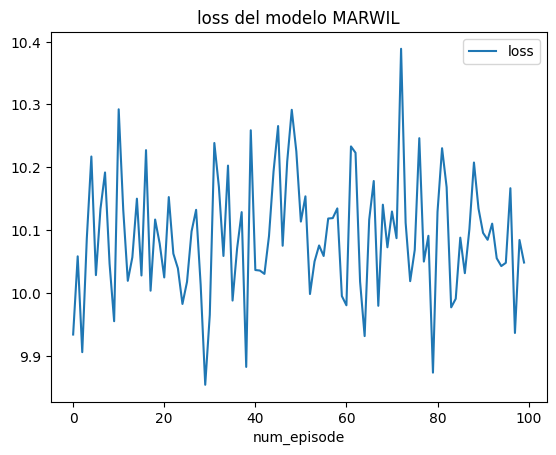

In [54]:
df.plot(x="num_episode",y="loss")
plt.title("loss del modelo MARWIL")

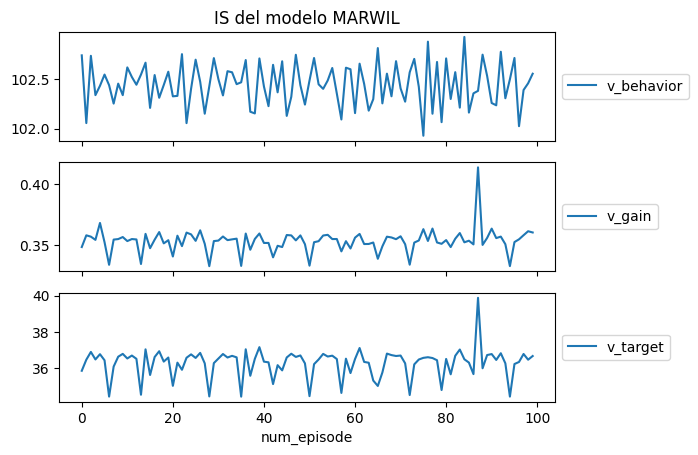

In [55]:
is_metric = df[df.offline_method=="IS"].set_index("num_episode")
fig, ax = plt.subplots(nrows=3, sharex=True)

is_metric.plot(y="v_behavior",label="v_behavior",ax=ax[0])
ax[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax[0].set_title("IS del modelo MARWIL")

is_metric.plot(y="v_gain",label="v_gain",ax=ax[1])
ax[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


is_metric.plot(y="v_target",label="v_target",ax=ax[2])
ax[2].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


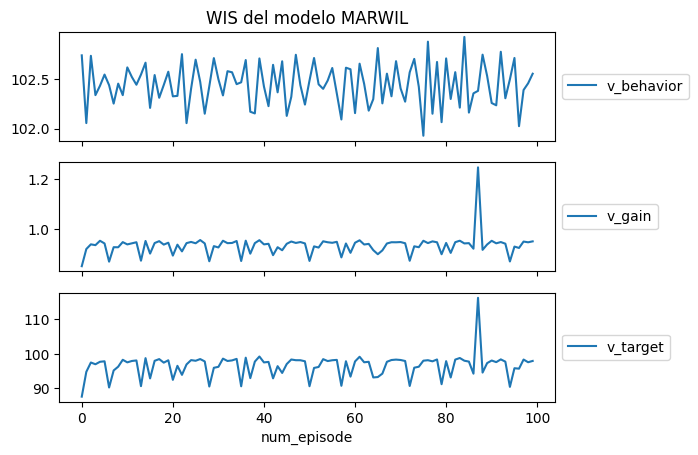

In [56]:
wis_metric = df[df.offline_method=="WIS"].set_index("num_episode")
fig, ax = plt.subplots(nrows=3, sharex=True)

wis_metric.plot(y="v_behavior",label="v_behavior",ax=ax[0])
ax[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax[0].set_title("WIS del modelo MARWIL")

wis_metric.plot(y="v_gain",label="v_gain",ax=ax[1])
ax[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


wis_metric.plot(y="v_target",label="v_target",ax=ax[2])
ax[2].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


In [57]:
fname = '../models/offline_rl/interest_evolution/BCTrainer/offline_metrics.csv'
df = pd.read_csv(fname)
df.head()

,num_episode,v_behavior,v_target,v_gain,v_behavior_std,v_target_std,v_gain_std,offline_method,loss,model,time
0,0,102.619356,39.182968,0.378720,13.247511,76.224650,0.724945,IS,NaN,BCTrainer,1541.399937
1,1,102.522018,39.561121,0.382448,13.163751,76.654479,0.729418,IS,NaN,BCTrainer,1541.399937
2,2,102.443820,39.644894,0.384783,12.887895,77.078413,0.733617,IS,NaN,BCTrainer,1541.399937
3,3,102.546519,37.587165,0.363779,12.869636,71.605778,0.679060,IS,NaN,BCTrainer,1541.399937
4,4,102.667207,40.520922,0.392761,13.466870,78.023716,0.742317,IS,NaN,BCTrainer,1541.399937


Text(0.5, 1.0, 'loss del modelo BC')

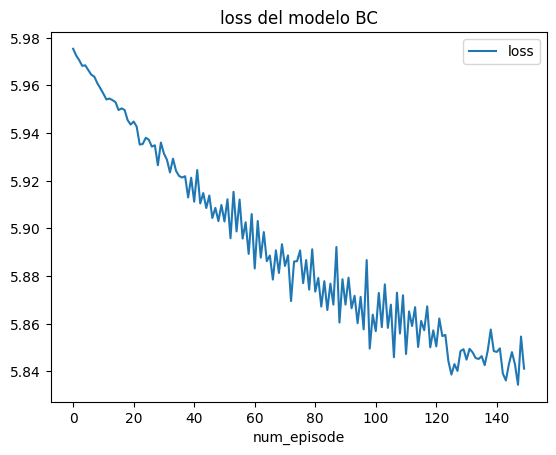

In [58]:
df.plot(x="num_episode",y="loss")
plt.title("loss del modelo BC")

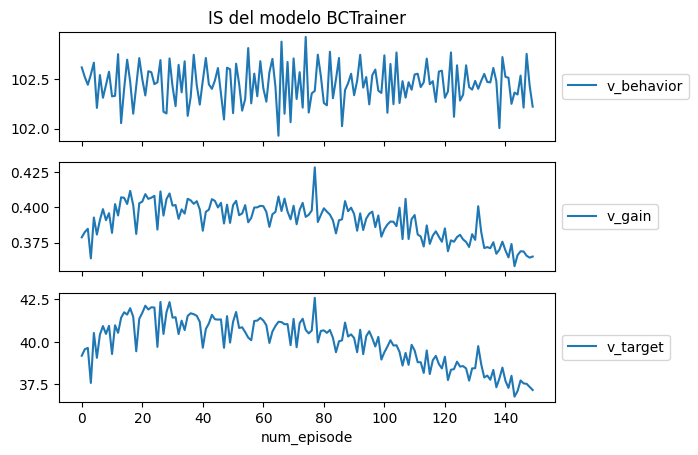

In [59]:
is_metric = df[df.offline_method=="IS"].set_index("num_episode")
fig, ax = plt.subplots(nrows=3, sharex=True)

is_metric.plot(y="v_behavior",label="v_behavior",ax=ax[0])
ax[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax[0].set_title("IS del modelo BCTrainer")

is_metric.plot(y="v_gain",label="v_gain",ax=ax[1])
ax[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


is_metric.plot(y="v_target",label="v_target",ax=ax[2])
ax[2].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

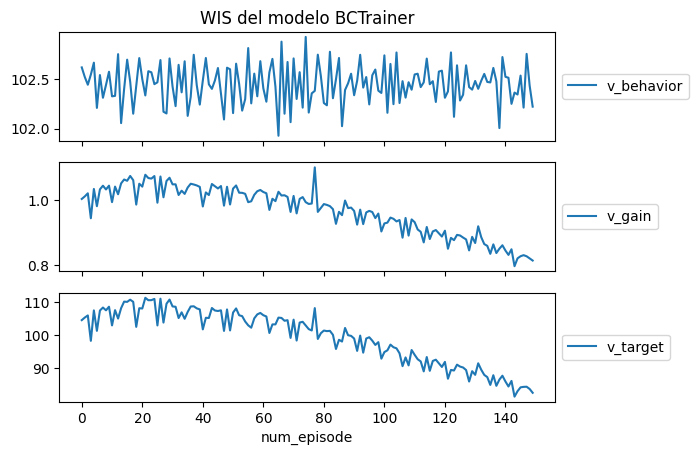

In [62]:
wis_metric = df[df.offline_method=="WIS"].set_index("num_episode")
fig, ax = plt.subplots(nrows=3, sharex=True)

wis_metric.plot(y="v_behavior",label="v_behavior",ax=ax[0])
ax[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax[0].set_title("WIS del modelo BCTrainer")

wis_metric.plot(y="v_gain",label="v_gain",ax=ax[1])
ax[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


wis_metric.plot(y="v_target",label="v_target",ax=ax[2])
ax[2].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))